In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.mapping_utils as mu

***
#### Download the data
- We will use [snRNA-seq data](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/mop_P_allen.h5ad.gz) (adult mouse brain; MOp area).
- And [Slide-seq2 data](
https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_cropped_DUAL.h5ad.gz) (adult mouse brain; MOp area).
- We will map them via a few hundred [marker genes](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/MOp_markers.csv).
- The two datasets should be unzipped. The two `h5ad` files and the `csv` file should be placed in the `data` folder.

***
#### Slide-seq data
- Slide-seq data contains 9852 spatial voxels, in each of which they measured 24518 genes.

In [ ]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

- We visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

In [ ]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);

raw count? Visualize marker?

***
#### Single cell data

- By single cell data, we mean either scRNAseq or snRNAseq.
- The following dataset contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 53k cells.

In [ ]:
path = os.path.join('data','mop_P_allen.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

In [ ]:
df_obs  = ad_sc.obs.sample(frac=.7)
ad_sc = ad_sc[df_obs.index, :].copy()

- Usually, we work with data in raw count form (but not necessarily), especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.

In [ ]:
np.unique(ad_sc.X.toarray()[0, :])

- We only do some light pre-processing such as library size correction (in scanpy, `sc.pp.normalize`).
- That normalize the number of count within each cell to a fixed number.
- Note that the resulting values might not be integer, still they quality as "count form".
- More sophisticated pre-processing is also possible, such as batch correction.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible.

In [ ]:
sc.pp.normalize_total(ad_sc)

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, we use the `subclass_label` annotations which contain the cell type.
- Here we show a count

In [ ]:
ad_sc.obs.subclass_label.value_counts()

- For this mapping, we exclude cell types which are rare in the snRNAseq.
- Actually, Tangram can "reuse" the same cell multiple times because mapping is probabilistic.
- But for this case, we want Tangram to have "enough puzzle pieces" for each cell type.

In [ ]:
rare_cts = ['Meis2', 'SMC', 'Sst Chodl']
mask = ~ad_sc.obs.subclass_label.isin(rare_cts)
ad_sc = ad_sc[mask, :]
ad_sc.obs.subclass_label.value_counts()

***
#### Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- Tangram restricts the search only to a set of genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).

In [ ]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

- We now need to prepare the datasets for mapping.
- The two `AnnData` structures need to be subset on the list of training genes.
- Second, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- This task is performed by the helper `prepare_adatas_cell_space`.

In [ ]:
ad_sc, ad_sp = mu.prepare_adatas_cell_space(
    adata_cells=ad_sc, 
    adata_space=ad_sp, 
    marker_genes=markers
)

- You'll now notice that the two datasets now contain 252 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `prepare_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `AnnData`s are actually ordered.

In [ ]:
ad_sc

In [ ]:
assert ad_sc.var.index.equals(ad_sp.var.index)

- At this point, it is a good to save the structures, then restart the python kernel.
- This is because we want to free as much memory as possible so that we can map.

In [ ]:
ad_sc.write_h5ad('ad_sc_readytomap.h5ad')

In [ ]:
ad_sp.write_h5ad('ad_sp_readytomap.h5ad')

***
#### Map

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.mapping_utils as mu

In [2]:
ad_sp = sc.read_h5ad('ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('ad_sc_readytomap.h5ad')

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus (which can be controlled by passing the `num_epochs` parameter). 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data. 
- We obtained some excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- In the basic mapping version we do not use regularizers (hence the `NaN`). More sophisticated loss function can be used using the Tangram library.

In [3]:
ad_map = mu.map_cells_to_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
)

Score: 0.102, KL reg: nan, VG reg: nan
Score: 0.789, KL reg: nan, VG reg: nan
Score: 0.807, KL reg: nan, VG reg: nan
Score: 0.812, KL reg: nan, VG reg: nan
Score: 0.814, KL reg: nan, VG reg: nan
Score: 0.815, KL reg: nan, VG reg: nan
Score: 0.816, KL reg: nan, VG reg: nan
Score: 0.816, KL reg: nan, VG reg: nan
Score: 0.817, KL reg: nan, VG reg: nan
Score: 0.817, KL reg: nan, VG reg: nan


- The mapping results are stored in an `AnnData` structure.
- The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
- The `obs` dataframe contains the metadata of the single cells.
- The `var` dataframe contains the metadata of the spatial data.
- The `uns` dictionary contains the training genes (TODO)

In [5]:
ad_map

AnnData object with n_obs × n_vars = 36997 × 9852
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    var: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

In [17]:
import mapping.utils as ut
df = ut.one_hot_encoding(ad_map.obs.subclass_label)
df_ct_prob = ad_map.X.T @ df
df_ct_prob

,L5/6 NP,Pvalb,Micro-PVM,L5 IT,Sst,Astro,L2/3 IT,Oligo,L6 CT,Sncg,Lamp5,Vip,Endo,L6 IT,Peri,L5 ET,L6b,VLMC
0,0.605993,0.599058,4.708322,10.734573,0.002797,7.610974,0.605959,13.989314,2.146465,0.292262,0.000201,0.001961,0.000415,0.577910,0.001433,0.000406,0.000242,2.032936
1,1.875481,3.476939,14.908031,13.212695,2.964338,8.025804,14.598821,14.896675,6.200666,0.659110,2.291335,0.205971,2.819821,2.039196,2.189989,4.258575,1.559813,2.796672
2,0.000798,9.216573,3.488431,9.334621,0.367586,0.010190,3.289893,1.054515,6.421720,0.000268,1.102212,0.102538,0.658022,0.000951,0.415187,3.918680,0.000370,0.139982
3,0.000316,17.313571,2.526724,2.214350,0.247678,13.434741,1.555947,12.171798,0.689475,0.000143,0.038424,0.218924,0.596196,0.000599,0.017622,0.000875,0.000127,0.510038
4,0.000391,0.001416,1.876170,6.039149,0.001363,1.172741,2.128360,5.821978,5.894763,0.032775,0.000537,0.122362,1.062230,4.704953,0.010873,0.001048,1.602932,0.025551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847,0.003405,0.002287,0.000398,0.004890,0.001914,0.000947,0.003279,0.001980,0.002396,0.012323,0.000405,0.006353,0.000139,0.000907,0.000724,0.000958,0.000299,0.000441
9848,0.000527,0.002063,0.000292,0.004877,0.007623,0.001000,0.009097,0.001571,0.002434,0.004118,0.019272,0.009603,0.000140,0.000881,0.000695,0.000897,0.000347,0.004735
9849,0.000576,0.016274,0.000302,0.004473,0.028793,0.000939,0.003201,0.001629,0.002264,0.000897,0.000498,0.012247,0.000138,0.000935,0.002919,0.002964,0.000268,0.000290
9850,0.000798,0.002851,0.000333,0.004871,0.001962,0.001034,0.156312,0.001816,0.002343,0.000776,0.000423,0.016751,0.000191,0.001052,0.000921,0.001119,0.000580,0.000475


In [23]:
len(df_ct_prob.columns)

18

TODO x and y must always be x and y

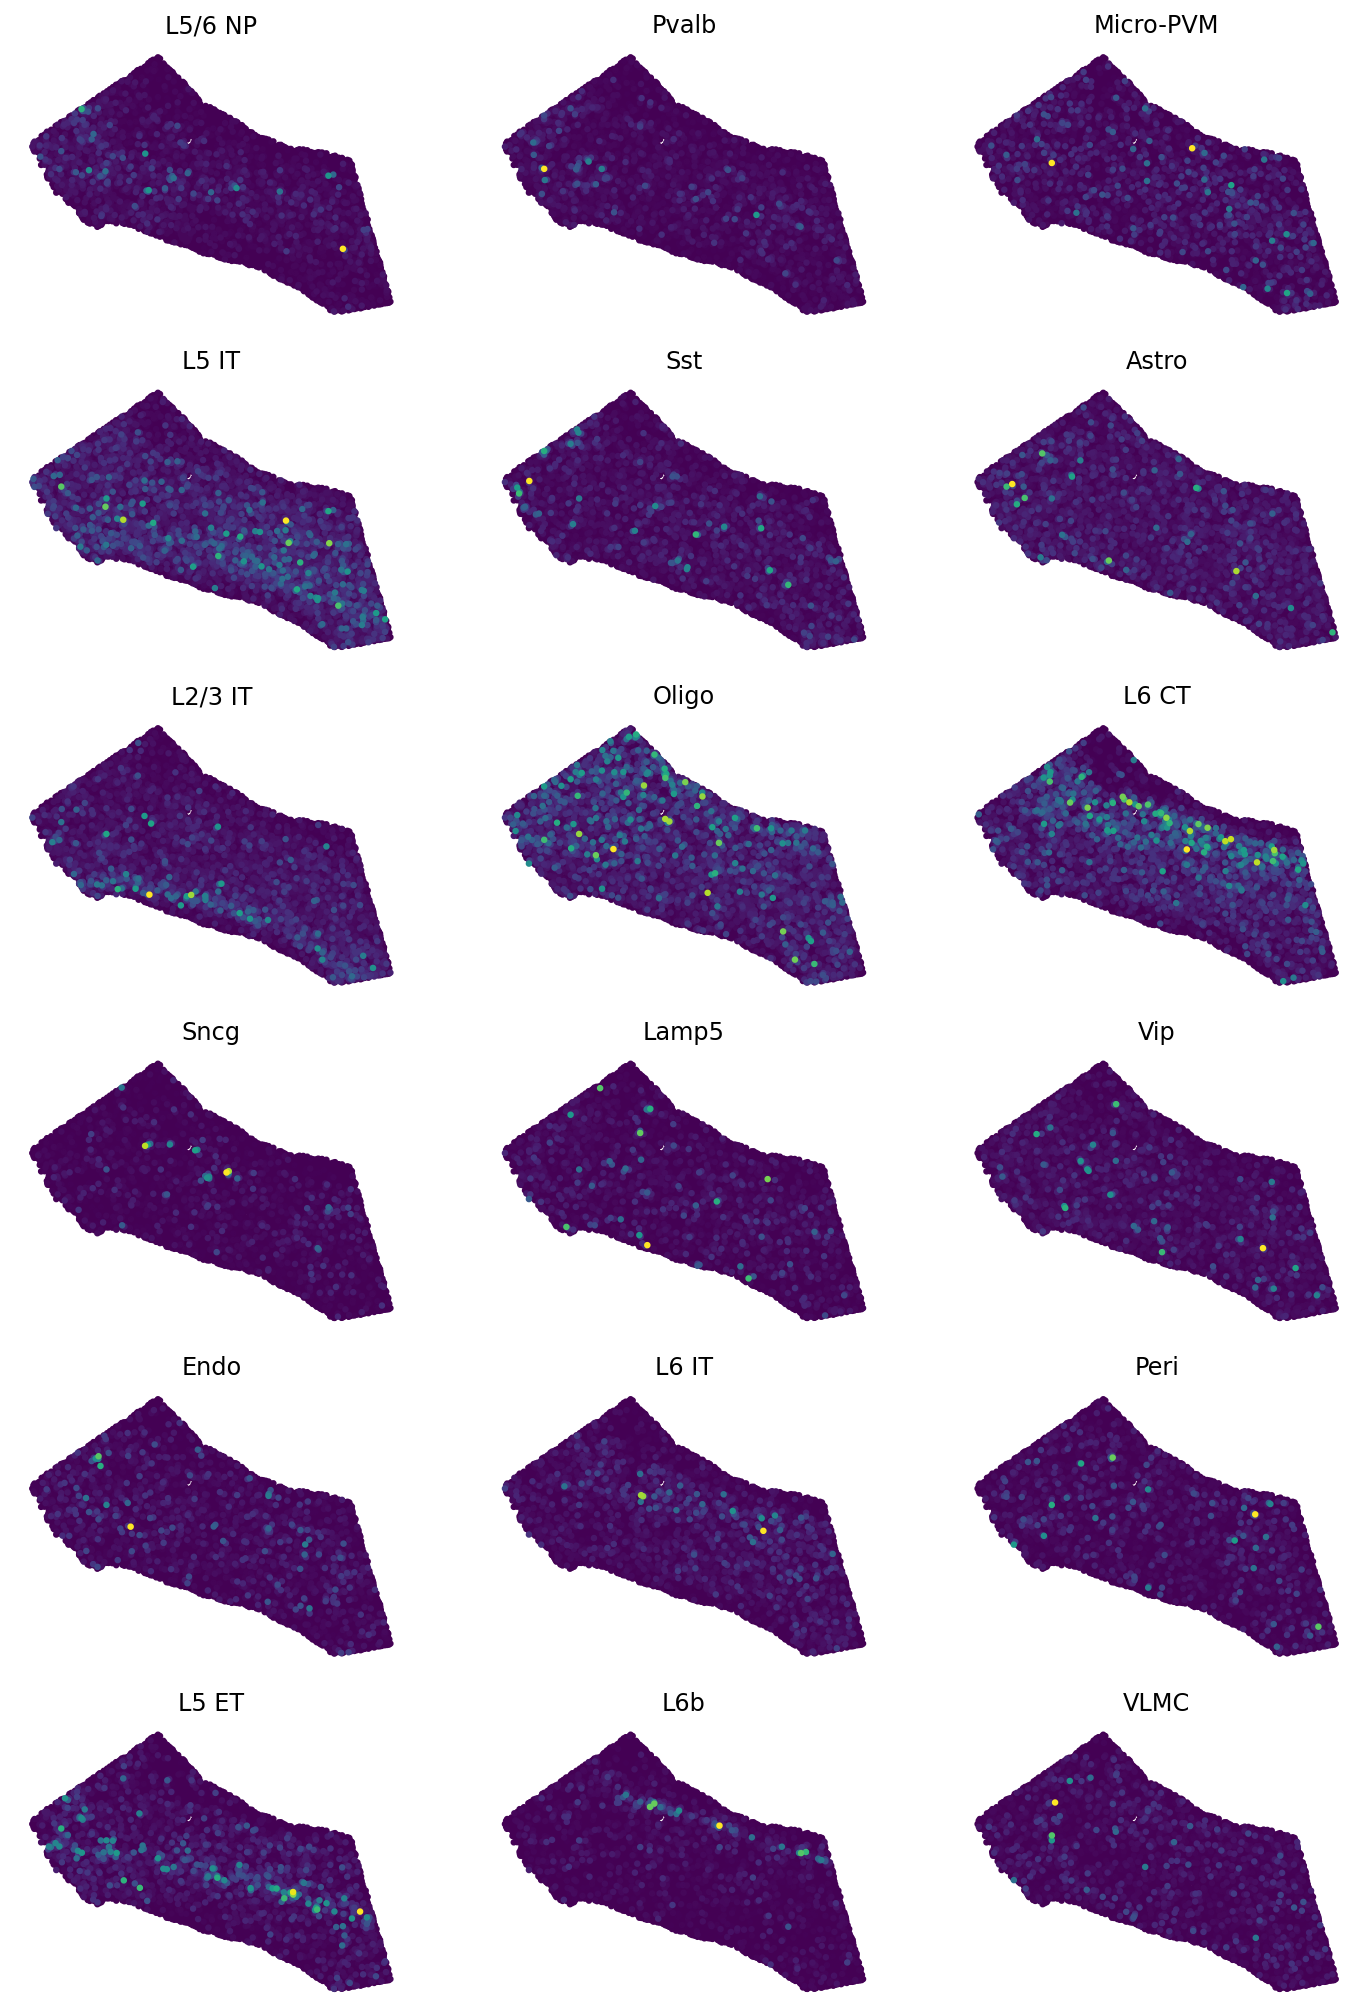

In [24]:
import mapping.plot_utils as pu


fig, axs = plt.subplots((len(df_ct_prob.columns) // 3), 3, 
                          figsize=(12, len(df_ct_prob.columns)), 
                          sharex=True, sharey=True) 

axs_f = axs.flatten()
for index, i in enumerate(df_ct_prob.columns):
    xs, ys, preds = pu.ordered_predictions(ad_map.var.x, 
                                        ad_map.var.y, 
                                        df_ct_prob[i])
    axs_f[index].scatter(x=xs, y=ys, c=preds, s=5, cmap='viridis')
    axs_f[index].axis('off')
    axs_f[index].set_title(i)